In [1]:
import os
os.chdir('..')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn
patch_sklearn()

from statistics import mode
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
original_data = pd.read_csv('data/dataset.csv')

df = original_data.copy()
df.head()

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
0,0,8.332988,0.000083,8.605777,122.799772,3.713298e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.269945e-15,332.118789,NaN,NaN,43.493324,January,29.0,4.0,0
1,1,6.917863,0.000081,3.734167,227.029851,7.849262e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.024076e-07,284.641984,Lake,15.348981,71.220586,November,26.0,16.0,0
2,2,5.443762,0.020106,3.816994,230.995630,5.286616e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,3.414619,275.702107,990.201209,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,January,31.0,8.0,0
3,3,7.955339,0.143988,8.224944,178.129940,3.997118e-176,4.027879,Near Colorless,0.166319,0.208454,0.239451,NaN,147.163233,237.028467,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,April,1.0,21.0,0
4,4,8.091909,0.002167,9.925788,186.540872,4.171069e-132,3.807511,Light Yellow,0.004867,0.222912,0.616574,0.795310,175.275175,385.025855,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,June,29.0,7.0,0


In [3]:
df.shape

(5956842, 24)

### Handelling Missing Values

In [5]:
# Filling with mean - 

missing_val_columns = ['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc',
       'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity',
       'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Water Temperature', 'Air Temperature']

for col in missing_val_columns:
    df[col].fillna(df[col].mean(), inplace = True)

In [6]:
# Filling with mapping

df['Color'].fillna('Near Colorless', inplace=True)
color_mapping = df.groupby('Color')['Color'].transform('count') / len(df)

df['Color'] = color_mapping

In [7]:
# Filling with mode

df['Source'] = df['Source'].fillna('Stream')

encoder = OrdinalEncoder()
df['Source'] = encoder.fit_transform(df[['Source']])

In [8]:
# Deleting non important columns

del df['Day']
del df['Index']
del df['Month']
del df['Time of Day']

In [9]:
df.columns

Index(['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Color',
       'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity',
       'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Source',
       'Water Temperature', 'Air Temperature', 'Target'],
      dtype='object')

### Feature Engineering

In [10]:
# Binning Iron based on the histogram (Low, Moderate and High)

bin_edges = [0, 0.1, 1, 20]
bin_labels = [0, 0.4, 1]
df['Iron_Bin'] = pd.cut(df['Iron'], bins = bin_edges, labels = bin_labels)

# Nitrate
bin_edges = [0, 1, 5, 100] 
df['Nitrate_Bin'] = pd.cut(df['Nitrate'], bins=bin_edges, labels=bin_labels)

# Copper
bin_edges = [0, 0.02, 1, 20]
df['Copper_Bin'] = pd.cut(df['Copper'], bins=bin_edges, labels=bin_labels)

### Validation Strategy

In [11]:
# Choosing two validation datasets, in order to get a better idea of the model performance.
# Taking only 10% of the data for validation because of the very large size of the dataset.

X = df.drop('Target', axis = 1)
y = df['Target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42, shuffle = True, stratify = y)
X_val_1, X_val_2, y_val_1, y_val_2 = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42, stratify = y_val)

X_train.shape, X_val_1.shape, X_val_2.shape, y_train.shape, y_val_1.shape, y_val_2.shape

((5361157, 22), (297842, 22), (297843, 22), (5361157,), (297842,), (297843,))

In [12]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_1_scaled = scaler.transform(X_val_1)
X_val_2_scaled = scaler.transform(X_val_2)

### Training

In [21]:
import mlflow
import daal4py as d4p
import lightgbm as lgb

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, ConfusionMatrixDisplay, f1_score, precision_score

In [24]:
mlflow.end_run()

In [25]:
params = {'reg_alpha': 5,
           'max_depth': 5,
           'reg_lambda': 1,
           'colsample_bytree': 0.33,
           'subsample': 0.0298,
           'learning_rate': 0.3878,
           }

mlflow.start_run()
mlflow.log_params(params)

clf = XGBClassifier(**params, random_state = 42, n_jobs = -1, tree_method = 'gpu_hist', early_stopping_rounds = 30)
clf.fit(X_train_scaled, y_train, eval_set=[(X_val_2_scaled, y_val_2)], verbose = 0)

callback = lgb.early_stopping(30)
lgbc = LGBMClassifier( n_estimators = 200000, random_state = 42, n_jobs = -1)
lgbc.fit(X_train_scaled, y_train, eval_set=[(X_val_2_scaled, y_val_2)], callbacks = [callback])

mlflow.end_run()

[LightGBM] [Info] Number of positive: 1624727, number of negative: 3736430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.380203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4357
[LightGBM] [Info] Number of data points in the train set: 5361157, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.303055 -> initscore=-0.832791
[LightGBM] [Info] Start training from score -0.832791
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.266709


In [27]:
print('predicting -')
y_pred_1_lgb = lgbc.predict(X_val_1_scaled)
y_pred_2_lgb = lgbc.predict(X_val_2_scaled)

y_pred_1_xgb = clf.predict(X_val_1_scaled)
y_pred_2_xgb = clf.predict(X_val_2_scaled)

y_pred_1 = [mode([y_pred_1_lgb[i], y_pred_1_xgb[i]]) for i in range(len(y_pred_1_lgb))]
y_pred_2 = [mode([y_pred_2_lgb[i], y_pred_2_xgb[i]]) for i in range(len(y_pred_2_lgb))]

print('Accuracy on validation set 1: ', accuracy_score(y_val_1, y_pred_1))
print('Accuracy on validation set 2: ', accuracy_score(y_val_2, y_pred_2))
print('Recall on validation set 1: ', recall_score(y_val_1, y_pred_1))
print('Recall on validation set 2: ', recall_score(y_val_2, y_pred_2))
print('Precision on validation set 1: ', precision_score(y_val_1, y_pred_1))
print('Precision on validation set 2: ', precision_score(y_val_2, y_pred_2))
print('F1 on validation set 1: ', f1_score(y_val_1, y_pred_1))
print('F1 on validation set 2: ', f1_score(y_val_2, y_pred_2))

predicting -
Accuracy on validation set 1:  0.8820112677191263
Accuracy on validation set 2:  0.8814308209358622
Recall on validation set 1:  0.9734882896456981
Recall on validation set 2:  0.9728349379036815
Precision on validation set 1:  0.7284899434578587
Precision on validation set 2:  0.7276712464988315
F1 on validation set 1:  0.8333554628224582
F1 on validation set 2:  0.8325803438941484


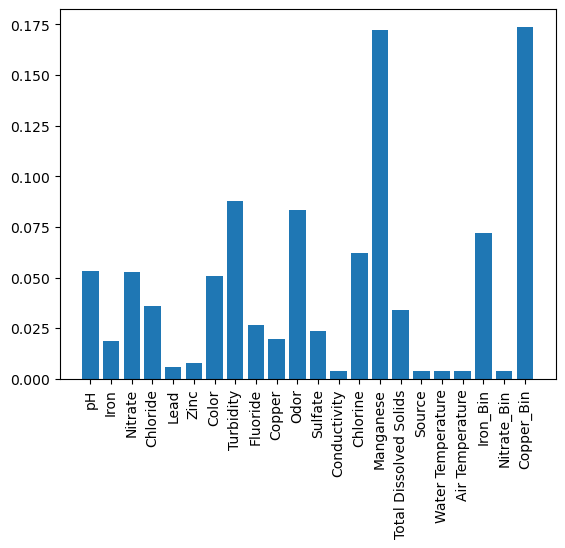

In [28]:
plt.bar(X_train.columns, clf.feature_importances_)
plt.xticks(rotation = 90)

plt.show()

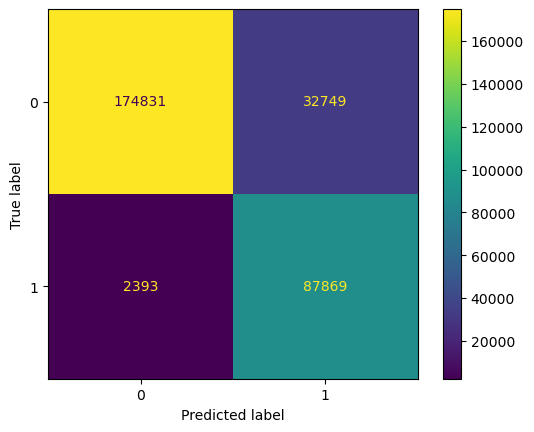

In [29]:
cm = confusion_matrix(y_val_1, y_pred_1)
ConfusionMatrixDisplay(cm).plot()

### Serialization

In [30]:
import joblib

with open('model/lgb_model.joblib','wb') as out:
    joblib.dump(lgbc, out)

joblib.dump(scaler, 'model/scaler.joblib')
joblib.dump(encoder, 'model/ordinal_encoder.joblib')

['model/ordinal_encoder.joblib']

In [35]:
daal_model = d4p.get_gbt_model_from_xgboost(clf.get_booster())

with open('model/xgb_model.joblib','wb') as out:
    joblib.dump(daal_model, out)